# Sparkify Capstone Project

## Business Understanding

Churn modeling is one of the common analytics problems faced by data scientists working with business teams. It impacts the revenue of the company directly. Churn modeling has some interesting constraints and implications for data scientists as the dataset is imbalanced and also model interpretability is an important requirement.

In this project, we will look at user interaction logs for a fictional music streaming company Sparkify. The full dataset is 12GB and would need a spark cluster to work with. We have explored the mini(128 MB) locally and medium(230 MB) datasets on IBM Watson cluster. This project familiarizes us with PySpark library for handling Big Data. We walk through the entire data lifecycle in this project and also present the findings for technical audience in a Medium post. 

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, lit
from pyspark.sql.functions import max as Fmax
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Capstone Project") \
    .getOrCreate()

### Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')

In [4]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

## Data Understanding

### Churn
Churn is defined as a Cancellation Confirmation action.
We can also look at Downgrade event, which is when a user downgrades their subscription from Paid level to Free level.

In [5]:
df.count()

286500

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.select('userId').dropDuplicates().sort('userId').show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



All possible user actions

In [8]:
df.select(col('page')).dropDuplicates().show(25)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



Actions without any user id are where user has not registered yet or is looking to login.

In [9]:
blank_pages = df.filter(df.userId == '') \
    .select(col('page') \
    .alias('blank_pages')) \
    .dropDuplicates()
blank_pages.show()

+-------------------+
|        blank_pages|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [10]:
df.select(['itemInSession', 'userId', 'sessionId']).groupBy(['userId', 'sessionId']).agg({'itemInSession': 'avg'}).sort('userId').collect()

[Row(userId='', sessionId=268, avg(itemInSession)=112.06666666666666),
 Row(userId='', sessionId=565, avg(itemInSession)=162.6),
 Row(userId='', sessionId=814, avg(itemInSession)=121.73333333333333),
 Row(userId='', sessionId=1053, avg(itemInSession)=30.0),
 Row(userId='', sessionId=1183, avg(itemInSession)=125.0),
 Row(userId='', sessionId=1305, avg(itemInSession)=293.1),
 Row(userId='', sessionId=1446, avg(itemInSession)=288.25),
 Row(userId='', sessionId=1592, avg(itemInSession)=32.833333333333336),
 Row(userId='', sessionId=164, avg(itemInSession)=0.3333333333333333),
 Row(userId='', sessionId=187, avg(itemInSession)=29.2),
 Row(userId='', sessionId=485, avg(itemInSession)=28.142857142857142),
 Row(userId='', sessionId=1023, avg(itemInSession)=11.0),
 Row(userId='', sessionId=1163, avg(itemInSession)=17.0),
 Row(userId='', sessionId=1392, avg(itemInSession)=4.5),
 Row(userId='', sessionId=1359, avg(itemInSession)=119.0),
 Row(userId='', sessionId=1595, avg(itemInSession)=87.5),
 Ro

In [11]:
df.select('sessionId').dropDuplicates().sort('sessionId').show(10)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
+---------+
only showing top 10 rows



In [12]:
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
df.count()

286500

In [13]:
df = df[df.userId != ""]
df.count()

278154

In [14]:
df.where(col("ts").isNull())

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

Convert timestamps to useable datetime formats

In [15]:
new_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
df = df.withColumn('updated_registration', new_ts('registration'))
df = df.withColumn('updated_ts', new_ts('ts'))

In [16]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', updated_registration='09-28-2018 22:22:42', updated_ts='10-01-2018 00:01:57'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', updated_registration='09-30-2018 18:20:30', updated_ts='10-01-2018 00:03:00'),


In [17]:
# Checking Downgrade event
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("downgrade_event", flag_downgrade_event("page"))

In [18]:
windowval = Window.partitionBy('userId')
df = df.withColumn('downgrade', Fmax('downgrade_event').over(windowval))

In [19]:
# Checking Cancellation event
churn_value = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn("churn_value", churn_value("page"))

churn_window = Window.partitionBy('UserId')
df = df.withColumn("user_churn", Fmax('churn_value').over(churn_window))

In [20]:
df_pd = df.toPandas()

In [21]:
df_pd.head().T

,0,1,2,3,4
artist,Sleeping With Sirens,Francesca Battistelli,Brutha,None,Josh Ritter
auth,Logged In,Logged In,Logged In,Logged In,Logged In
firstName,Darianna,Darianna,Darianna,Darianna,Darianna
gender,F,F,F,F,F
itemInSession,0,1,2,3,4
lastName,Carpenter,Carpenter,Carpenter,Carpenter,Carpenter
length,202.971,196.545,263.131,NaN,316.238
level,free,free,free,free,free
location,"Bridgeport-Stamford-Norwalk, CT","Bridgeport-Stamford-Norwalk, CT","Bridgeport-Stamford-Norwalk, CT","Bridgeport-Stamford-Norwalk, CT","Bridgeport-Stamford-Norwalk, CT"
method,PUT,PUT,PUT,PUT,PUT


In [22]:
df_pd.describe()

,itemInSession,length,registration,sessionId,status,ts,downgrade_event,downgrade,churn_value,user_churn
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05,278154.000000,278154.000000,278154.000000,278154.000000
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,1.540959e+12,0.000226,0.383428,0.000187,0.161292
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.506829e+09,0.015048,0.486222,0.013672,0.367801
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12,0.000000,0.000000,0.000000,0.000000
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,1.539699e+12,0.000000,0.000000,0.000000,0.000000
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,1.540934e+12,0.000000,0.000000,0.000000,0.000000
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.542268e+12,0.000000,1.000000,0.000000,0.000000
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12,1.000000,1.000000,1.000000,1.000000


In [23]:
(df_pd.groupby(['userId', 'level', 'sessionId'])['itemInSession'].mean()).groupby(['userId', 'level']).mean().reset_index()

,userId,level,itemInSession
0,10,paid,67.771889
1,100,free,44.877114
2,100,paid,53.290452
3,100001,free,25.303713
4,100002,paid,26.772727
5,100003,free,21.105263
6,100004,free,28.552915
7,100004,paid,56.012482
8,100005,free,21.703175
9,100006,free,21.772727


Text(0.5,1,'Distribution of Users by churn')

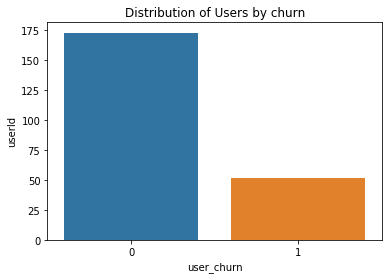

In [24]:
churn_df = df_pd.groupby('user_churn').userId.nunique().reset_index()
sns.barplot(churn_df.user_churn, churn_df.userId)
plt.title('Distribution of Users by churn')

**Highly Imbalanced Dataset**

Text(0.5,1,'Distribution of users by Subscription level')

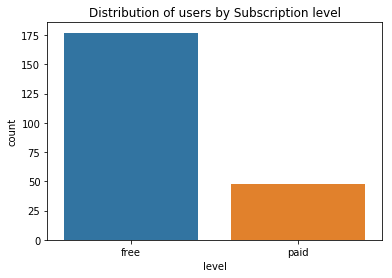

In [60]:
sns.countplot(df_pd.drop_duplicates('userId').level)
plt.title('Distribution of users by Subscription level')

More free users than paid users

In [26]:
df_pd.groupby('gender').userId.nunique()

gender
F    104
M    121
Name: userId, dtype: int64

Dataset is almost balanced wrt gender of users

Text(0.5,1,'Distribution of churned users by gender')

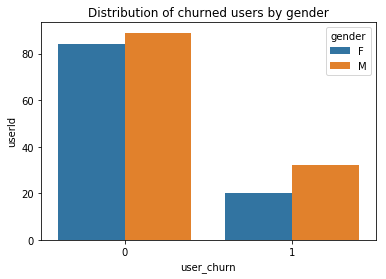

In [27]:
churn_by_gender = df_pd.groupby(['user_churn', 'gender']).userId.nunique().reset_index()
sns.barplot(churn_by_gender.user_churn, churn_by_gender.userId, hue=churn_by_gender.gender)
plt.title('Distribution of churned users by gender')

Text(0.5,1,'Percent of churned users by Subscription level')

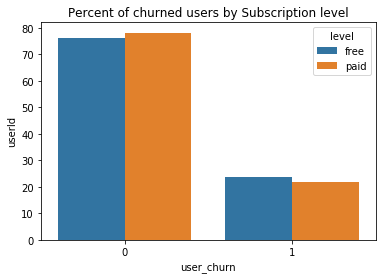

In [28]:
churn_by_level = df_pd.groupby(['level', 'user_churn']).userId.nunique()
churn_pcts = churn_by_level.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).reset_index()
sns.barplot(churn_pcts.user_churn, churn_pcts.userId, hue=churn_pcts.level)
plt.title('Percent of churned users by Subscription level')

Churn is almost same for free and paid subscription users wrt churn

Text(0.5,1,'Number of songs per session by Subscription level')

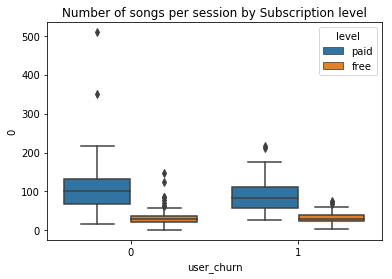

In [29]:
num_songs = df_pd[df_pd.page=='NextSong'].groupby(['user_churn', 'userId', 'sessionId', 'level']).size()\
                             .groupby(['user_churn', 'userId', 'level']).mean().reset_index()
sns.boxplot(num_songs.user_churn, num_songs[0], hue=num_songs.level)
plt.title('Number of songs per session by Subscription level')

Paid users have much higher usage per session compared to free users.

In [110]:
df_pd.artist.value_counts().head(15)

Kings Of Leon             1841
Coldplay                  1813
Florence + The Machine    1236
Dwight Yoakam             1135
BjÃÂ¶rk                  1133
The Black Keys            1125
Muse                      1090
Justin Bieber             1044
Jack Johnson              1007
Eminem                     953
Radiohead                  884
Alliance Ethnik            876
Train                      854
Taylor Swift               840
OneRepublic                828
Name: artist, dtype: int64

## Data Preparation

We aggregate data at user-level from interactions to identify features for churn prediction. 

In [31]:
total_songs = df.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'total_songs')
total_songs.show(10)

+------+-----------+
|userId|total_songs|
+------+-----------+
|100010|        381|
|200002|        474|
|   125|         11|
|    51|       2464|
|   124|       4825|
|     7|        201|
|    54|       3437|
|    15|       2278|
|   155|       1002|
|   132|       2304|
+------+-----------+
only showing top 10 rows



In [32]:
total_length = df.select('userId', 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'total_length')
total_length.show(10)

+------+------------------+
|userId|      total_length|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
|     7| 38034.08710000002|
|    54| 711344.9195400011|
|    15|477307.60581000015|
|   155|       198779.2919|
|   132| 483118.9038399997|
+------+------------------+
only showing top 10 rows



In [33]:
thumbs_up = df.select('userId', 'page').where(df.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'thumbs_up')
thumbs_down = df.select('userId', 'page').where(df.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'thumbs_down')

In [34]:
user_lifetime = df.select('userId', 'registration', 'ts').withColumn('tot_lifetime', (df.ts - df.registration))\
    .groupBy('userId').agg({'tot_lifetime' : 'max'})\
    .withColumnRenamed('max(tot_lifetime)', 'tot_lifetime')\
    .select('userId', (col('tot_lifetime')/1000/3600/24).alias('user_lifetime'))
user_lifetime.show(10)

+------+------------------+
|userId|     user_lifetime|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
|     7| 72.77818287037037|
|    54|110.75168981481481|
|    15|56.513576388888886|
|   155|23.556018518518517|
|   132|  66.8891087962963|
+------+------------------+
only showing top 10 rows



In [35]:
friends_added = df.select('userId', 'page').where(df.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'friends_added')
friends_added.show(10)

+------+-------------+
|userId|friends_added|
+------+-------------+
|100010|            4|
|200002|            4|
|    51|           28|
|   124|           74|
|     7|            1|
|    54|           33|
|    15|           31|
|   155|           11|
|   132|           41|
|   154|            3|
+------+-------------+
only showing top 10 rows



In [36]:
songs_per_session = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby('userId')\
          .agg({'count' : 'avg'}).withColumnRenamed('avg(count)', 'songs_per_session')
songs_per_session.show(10)

+------+------------------+
|userId| songs_per_session|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
+------+------------------+
only showing top 10 rows



In [37]:
total_artists = df.filter(df.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()\
         .withColumnRenamed("count", "total_artists")
total_artists.show(10)

+------+-------------+
|userId|total_artists|
+------+-------------+
|100010|          252|
|200002|          339|
|   125|            8|
|    51|         1385|
|   124|         2232|
|     7|          142|
|    15|         1302|
|    54|         1744|
|   155|          643|
|   132|         1299|
+------+-------------+
only showing top 10 rows



In [38]:
gender = df.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['1', '0'], 'gender').select('userId', col('gender').cast('int'))
gender.show(10)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|100010|     1|
|    40|     1|
|    94|     1|
|    35|     1|
+------+------+
only showing top 10 rows



In [39]:
playlist_added = df.select('userID','page').where(df.page == 'Add to Playlist').groupBy('userID').count().withColumnRenamed('count', 'playlist_added')
playlist_added.show(10)

+------+--------------+
|userID|playlist_added|
+------+--------------+
|100010|             7|
|200002|             8|
|    51|            52|
|   124|           118|
|     7|             5|
|    15|            59|
|    54|            72|
|   155|            24|
|   132|            38|
|   154|             1|
+------+--------------+
only showing top 10 rows



In [40]:
downgrade = df.select('userId', 'downgrade').dropDuplicates().select('userId', col('downgrade'))
gender.show(10)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|100010|     1|
|    40|     1|
|    94|     1|
|    35|     1|
+------+------+
only showing top 10 rows



In [41]:
user_churn = df.select('userId', col('user_churn')).dropDuplicates()
user_churn.show()

+------+----------+
|userId|user_churn|
+------+----------+
|100010|         0|
|200002|         0|
|   125|         1|
|   124|         0|
|    51|         1|
|     7|         0|
|    15|         0|
|    54|         1|
|   155|         0|
|100014|         1|
|   132|         0|
|   154|         0|
|   101|         1|
|    11|         0|
|   138|         0|
|300017|         0|
|100021|         1|
|    29|         1|
|    69|         0|
|   112|         0|
+------+----------+
only showing top 20 rows



In [42]:
final_df = total_songs.join(total_length, 'userId', 'inner').join(thumbs_up, 'userId', 'inner')\
                .join(thumbs_down, 'userId', 'inner').join(user_lifetime, 'userId', 'inner').join(songs_per_session, 'userId', 'inner')\
                .join(friends_added, 'userId', 'inner').join(playlist_added, 'userId', 'inner').join(gender, 'userId', 'inner')\
                .join(total_artists, 'userId', 'inner').join(downgrade, 'userId', 'inner')\
                .join(user_churn, 'userId', 'inner').drop('userId')

final_df.show(10)

+-----------+------------------+---------+-----------+------------------+------------------+-------------+--------------+------+-------------+---------+----------+
|total_songs|      total_length|thumbs_up|thumbs_down|     user_lifetime| songs_per_session|friends_added|playlist_added|gender|total_artists|downgrade|user_churn|
+-----------+------------------+---------+-----------+------------------+------------------+-------------+--------------+------+-------------+---------+----------+
|        381| 66940.89735000003|       17|          5|  55.6436574074074|39.285714285714285|            4|             7|     1|          252|        0|         0|
|        474| 94008.87593999993|       21|          6| 70.07462962962963|              64.5|            4|             8|     0|          339|        0|         0|
|       4825|1012312.0927899999|      171|         41|131.55591435185184|145.67857142857142|           74|           118|     1|         2232|        0|         0|
|       2464| 52

## Modeling

We convert features to numeric features and then scale them.
Dataset is split into train-validation-test set in 70:15:15 ratio.
Since the dataset is imbalanced, we use F1 as metric for evaluating the models, rather than accuracy.

After which fit different models on training dataset and check the performance on the validation set. Once we identify the best model, we perform hyperparameter tuning, after which we identify the best model.
The final model is used to make predictions for the test set.

In [43]:
assmblr = VectorAssembler(inputCols = ['total_songs', 'total_length', 'thumbs_up', 'thumbs_down', 'user_lifetime', 
                                       'songs_per_session', 'friends_added', 'playlist_added', 'gender', 'total_artists', 
                                       'downgrade'],
                          outputCol = "VectFeatures")
final_df = assmblr.transform(final_df)
final_df.show(5)

+-----------+------------------+---------+-----------+------------------+------------------+-------------+--------------+------+-------------+---------+----------+--------------------+
|total_songs|      total_length|thumbs_up|thumbs_down|     user_lifetime| songs_per_session|friends_added|playlist_added|gender|total_artists|downgrade|user_churn|        VectFeatures|
+-----------+------------------+---------+-----------+------------------+------------------+-------------+--------------+------+-------------+---------+----------+--------------------+
|        381| 66940.89735000003|       17|          5|  55.6436574074074|39.285714285714285|            4|             7|     1|          252|        0|         0|[381.0,66940.8973...|
|        474| 94008.87593999993|       21|          6| 70.07462962962963|              64.5|            4|             8|     0|          339|        0|         0|[474.0,94008.8759...|
|       4825|1012312.0927899999|      171|         41|131.55591435185184|14

In [44]:
scaler = StandardScaler(inputCol = 'VectFeatures', outputCol = "scaled_features", withStd = True)
scaler_model = scaler.fit(final_df)
final_df = scaler_model.transform(final_df)

In [45]:
final_df.show(5)

+-----------+------------------+---------+-----------+------------------+------------------+-------------+--------------+------+-------------+---------+----------+--------------------+--------------------+
|total_songs|      total_length|thumbs_up|thumbs_down|     user_lifetime| songs_per_session|friends_added|playlist_added|gender|total_artists|downgrade|user_churn|        VectFeatures|     scaled_features|
+-----------+------------------+---------+-----------+------------------+------------------+-------------+--------------+------+-------------+---------+----------+--------------------+--------------------+
|        381| 66940.89735000003|       17|          5|  55.6436574074074|39.285714285714285|            4|             7|     1|          252|        0|         0|[381.0,66940.8973...|[0.28303433540817...|
|        474| 94008.87593999993|       21|          6| 70.07462962962963|              64.5|            4|             8|     0|          339|        0|         0|[474.0,94008.

In [46]:
data = final_df.select(final_df.user_churn.alias("label"), final_df.scaled_features.alias("features"))

In [47]:
data.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.28303433540817...|
|    0|[0.35212145664954...|
|    0|[3.58435870956552...|
|    1|[1.83043727676051...|
|    0|[0.14931732655392...|
+-----+--------------------+
only showing top 5 rows



Train-test-validation split

In [48]:
train, rest = data.randomSplit([0.7, 0.3])
val, test = rest.randomSplit([0.5, 0.5])

In [49]:
train.select('label').agg({'label': 'sum'}).collect()

[Row(sum(label)=30)]

In [50]:
train.count()

141

**Baseline Model**
Predicts 0 for all records

In [51]:
dummy_classifier = val.withColumn('prediction', lit(0.0))

In [52]:
print('Dummy Classifier metrics:')
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Accuracy: {}'.format(evaluator.evaluate(dummy_classifier, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(dummy_classifier, {evaluator.metricName: "f1"})))
print('Recall Score:{}'.format(evaluator.evaluate(dummy_classifier, {evaluator.metricName: "weightedRecall"})))

Dummy Classifier metrics:
Accuracy: 0.7333333333333333
F-1 Score:0.6205128205128204
Recall Score:0.7333333333333333


In [53]:
lr = LogisticRegression(maxIter=20)
rf = RandomForestClassifier()
svc = LinearSVC(maxIter=20)
gb = GBTClassifier(maxIter=20)

In [54]:
model_lr = lr.fit(train)
results_lr = model_lr.transform(val)

print('Logistic Regression metrics:')
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Accuracy: {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))

Logistic Regression metrics:
Accuracy: 0.7333333333333333
F-1 Score:0.6205128205128204


In [55]:
model_rf = rf.fit(train)
results_rf = model_rf.transform(val)

print('Random Forest metrics:')
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Accuracy: {}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "f1"})))

Random Forest metrics:
Accuracy: 0.9
F-1 Score:0.8916530278232406


In [56]:
model_svc = svc.fit(train)
results_svc = model_svc.transform(val)

print('Linear SVC metrics:')
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Accuracy: {}'.format(evaluator.evaluate(results_svc, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_svc, {evaluator.metricName: "f1"})))

Linear SVC metrics:
Accuracy: 0.7333333333333333
F-1 Score:0.6205128205128204


In [57]:
gb = GBTClassifier(maxIter=15)
model_gb = gb.fit(train)
results_gb = model_gb.transform(val)

print('GB Tree metrics:')
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Accuracy: {}'.format(evaluator.evaluate(results_gb, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_gb, {evaluator.metricName: "f1"})))

GB Tree metrics:
Accuracy: 0.8666666666666667
F-1 Score:0.8499999999999999


### Hyper-parameter Tuning
Using F1 score, best model is Random Forest model. We tune the model. 

In [58]:
# Model Tuning
rf_tune = RandomForestClassifier()
f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid_rf_tune = ParamGridBuilder().addGrid(rf_tune.numTrees, [15, 20, 25, 30, 35, 40])\
                 .addGrid(rf_tune.maxDepth, [5, 10, 15]).build()

cross_rf_tune = CrossValidator(estimator = rf_tune, estimatorParamMaps = param_grid_rf_tune, evaluator = f1_evaluation, numFolds = 3)

In [61]:
model_rf_tune = cross_rf_tune.fit(train)
results_rf_tune = model_rf_tune.transform(val)

print('Random Tree Tuned metrics:')
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Accuracy: {}'.format(evaluator.evaluate(results_rf_tune, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_rf_tune, {evaluator.metricName: "f1"})))

Random Tree Tuned metrics:
Accuracy: 0.8333333333333334
F-1 Score:0.8039579468150897


**Making Predictions for Test set using Best Model**

In [64]:
results_test_rf = model_rf.transform(test)

print('Test Set metrics:')
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Accuracy: {}'.format(evaluator.evaluate(results_test_rf, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_test_rf, {evaluator.metricName: "f1"})))

Test Set metrics:
Accuracy: 0.8095238095238095
F-1 Score:0.7913165266106442


**Feature Importance**

In [90]:
model_rf.featureImportances.values

array([ 0.0895756 ,  0.07746056,  0.0528304 ,  0.09018961,  0.30425788,
        0.10439983,  0.0948268 ,  0.12410009,  0.01088739,  0.03733627,
        0.01413557])

In [102]:
df_feat_imp = pd.DataFrame([model_rf.featureImportances.values], columns=['total_songs','total_length','thumbs_up','thumbs_down',
                                                            'user_lifetime','songs_per_session','friends_added','playlist_added',
                                                            'gender','total_artists','downgrade'], index=['Feature_Importance']).T.sort_values('Feature_Importance')

In [96]:
import numpy as np

Text(0.5,1,'Feature Importance of RandomForest model')

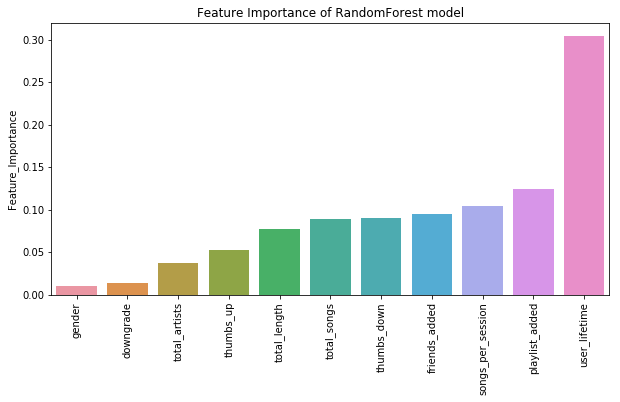

In [109]:
plt.figure(figsize=(10,5))
sns.barplot(df_feat_imp.index, df_feat_imp.Feature_Importance)
plt.xticks(rotation='vertical')
plt.title("Feature Importance of RandomForest model")

***Also trained the model for medium dataset on IBM Watson cluster***

## Next Steps
- We can train the model using full 12 GB dataset
- We can perform oversampling to balance the dataset
- We can explore additional features like device used by user.

**Blog detailing the analysis of this can be found [here](https://medium.com/@sakchhi.sri/churn-prediction-using-spark-1d8f6bd4092d).**